# 1. loading datasets

Training has to be done with dropout as data is not always present

In [64]:
import torch
import pandas as pd
import numpy as np
import time
import joblib

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset



In [65]:

from torch import nn 

# Check PyTorch version
print("PyTorch version:", torch.__version__)

# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())

# Get current CUDA device index (if available)
if torch.cuda.is_available():
    print("Current CUDA device index:", torch.cuda.current_device())
    print("CUDA device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("No CUDA devices found.")
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



PyTorch version: 2.5.0+cu118
CUDA available: True
Current CUDA device index: 0
CUDA device name: NVIDIA GeForce RTX 4070 SUPER


In [66]:
# Update with the correct path
# file_path = './Data/12_Sep_Readings/combined_data.csv'  
# file_path = './Data/15_Nov_Readings/augmented_rssi_dataset.csv'
file_path = './Data/25-02-10/cleaned_df.csv'
model_path = './models/Regression_based'
cleaned_df = pd.read_csv(file_path)

In [67]:
cleaned_df

,Tx_0 RSSI,Tx_1 RSSI,Tx_2 RSSI,Tx_3 RSSI,Tx_4 RSSI,Tx_5 RSSI,Tx_6 RSSI,Tx_7 RSSI,X_Coord,Y_Coord
0,-61,-74,-79,127,-81,-78,127,-84,0,0
1,-61,-73,-78,-71,127,-78,127,127,0,0
2,-62,-75,-78,-72,-79,127,-84,127,0,0
3,-61,-73,-80,-71,-83,-78,127,127,0,0
4,-61,-75,-78,-71,-84,-78,-84,-86,0,0
...,...,...,...,...,...,...,...,...,...,...
6395,-79,-69,-81,-74,-70,-61,-78,-68,6,0
6396,-77,-69,-77,-71,-70,-61,-79,-67,6,0
6397,-77,-69,-81,-73,-70,-61,-79,-66,6,0
6398,-80,-69,-77,-72,-71,-61,-76,-67,6,0


In [68]:

batt_columns = [col for col in cleaned_df.columns if 'Batt' in col]
time_columns = [col for col in cleaned_df.columns if 'Time' in col]
columns_to_drop = batt_columns+time_columns
RSSI_columns = cleaned_df.drop(columns=columns_to_drop)


#Train the model without NAN values
# cleaned_df = RSSI_columns.dropna()

#Convert NaN values to -100 or -999

# cleaned_df = RSSI_columns.fillna(0)
# cleaned_df = RSSI_columns.fillna(-999)




cleaned_df.shape

(6400, 10)

In [69]:
cleaned_df

,Tx_0 RSSI,Tx_1 RSSI,Tx_2 RSSI,Tx_3 RSSI,Tx_4 RSSI,Tx_5 RSSI,Tx_6 RSSI,Tx_7 RSSI,X_Coord,Y_Coord
0,-61,-74,-79,127,-81,-78,127,-84,0,0
1,-61,-73,-78,-71,127,-78,127,127,0,0
2,-62,-75,-78,-72,-79,127,-84,127,0,0
3,-61,-73,-80,-71,-83,-78,127,127,0,0
4,-61,-75,-78,-71,-84,-78,-84,-86,0,0
...,...,...,...,...,...,...,...,...,...,...
6395,-79,-69,-81,-74,-70,-61,-78,-68,6,0
6396,-77,-69,-77,-71,-70,-61,-79,-67,6,0
6397,-77,-69,-81,-73,-70,-61,-79,-66,6,0
6398,-80,-69,-77,-72,-71,-61,-76,-67,6,0


In [70]:
from common_utils import preprocess_dataset

X = cleaned_df[['Tx_0 RSSI', 'Tx_1 RSSI', 'Tx_2 RSSI', 'Tx_3 RSSI', 'Tx_4 RSSI', 'Tx_5 RSSI', 'Tx_6 RSSI', 'Tx_7 RSSI']]
# X = cleaned_df[['Tx_0 RSSI_Avg', 'Tx_1 RSSI_Avg', 'Tx_2 RSSI_Avg', 'Tx_3 RSSI_Avg', 'Tx_4 RSSI_Avg', 'Tx_5 RSSI_Avg', 'Tx_6 RSSI_Avg', 'Tx_7 RSSI_Avg']]



Y = cleaned_df[['X_Coord', 'Y_Coord']]

# Perform the train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Display the results
print("X_train:\n", X_train)
print("X_test:\n", X_test)
print("Y_train:\n", Y_train)
print("Y_test:\n", Y_test)

X_train:
       Tx_0 RSSI  Tx_1 RSSI  Tx_2 RSSI  Tx_3 RSSI  Tx_4 RSSI  Tx_5 RSSI  \
1859        -61        -68        -71        127        -70        -71   
3238        -75        -77        -80        -77        -60        -69   
5179        -76        127        -73        127        127        127   
2646        127        -73        -76        -71        -64        -52   
5676        127        -81        -66        -65        -73        -78   
...         ...        ...        ...        ...        ...        ...   
3772        -67        -70        127        -74        -78        127   
5191        -76        127        -72        127        -71        127   
5226        -77        127        -72        -78        127        127   
5390        -65        -61        -76        -80        -74        -72   
860         -57        -57        -67        127        127        -67   

      Tx_6 RSSI  Tx_7 RSSI  
1859        -82        -77  
3238        127        127  
5179        12

# 2. NN model

We will try to determine the optimal hyperparameters
1. Loss function
2. model depth and size, restricted to 3 layers

In [71]:
class MLPBuilder(nn.Module):

    def __init__(self, no_features, layers, no_labels = 64):
        super().__init__()
        layer_list = []
        
        # Input layer
        layer_list.append(nn.Linear(no_features, layers[0]))
        layer_list.append(nn.ReLU())
        layer_list.append(nn.Dropout(p=0.2))

        # Hidden layers
        for i in range(len(layers) - 1):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
            layer_list.append(nn.ReLU())
            layer_list.append(nn.Dropout(p=0.2))

        # Output layer, 2 outputs
        layer_list.append(nn.Linear(layers[-1], 2))
 
        # Define the MLP stack as a sequential model
        self.mlp_stack = nn.Sequential(*layer_list)

        self._initialize_weights() 
        
    def forward(self, x):
        logits = self.mlp_stack(x)
        return logits
    
    def _initialize_weights(self):
        for layer in self.mlp_stack:
            if isinstance(layer, nn.Linear):
                # Use Kaiming initialization for ReLU activations
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

In [72]:
scaler_X = MinMaxScaler()

# Normalize the input data (RSSI values) for both training and testing sets
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Initialize the scaler for the target coordinates (X_Coord, Y_Coord)
scaler_Y = MinMaxScaler()

# Normalize the target coordinates (X_Coord, Y_Coord) for both training and testing sets
Y_train_scaled = scaler_Y.fit_transform(Y_train)
Y_test_scaled = scaler_Y.transform(Y_test)

# Convert the normalized data to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
Y_train_tensor = torch.tensor(Y_train_scaled, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
Y_test_tensor = torch.tensor(Y_test_scaled, dtype=torch.float32).to(device)


# Create DataLoader for the training set
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create DataLoader for the test set
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # Shuffle is typically False for test data

In [73]:
joblib.dump(scaler_X, model_path + '/scaler_X.pkl')
joblib.dump(scaler_Y, model_path + '/scaler_Y.pkl')

# scaler_X = joblib.load('./models/scales/scaler_X.pkl')
# scaler_Y = joblib.load('./models/scales/scaler_Y.pkl')

['./models/Regression_based/scaler_Y.pkl']

In [74]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to device

        optimizer.zero_grad() 
        outputs = model(inputs)  # Forward pass
        loss = loss_fn(outputs, targets)  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)  # Average loss for the epoch
    return avg_loss


def test_loop(dataloader, model, loss_fn):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    
    with torch.no_grad():  # No gradients needed during testing
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device

            outputs = model(inputs)  # Forward pass
            loss = loss_fn(outputs, targets)  # Compute the loss
            running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)  # Average loss for the epoch
    return avg_loss


In [75]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        """
        patience: number of epochs to wait for improvement in validation loss before stopping
        delta: minimum change to consider as an improvement
        """
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = float('inf')  # Initialize the best loss as infinity
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0  # Reset the counter if there's an improvement
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [76]:
import itertools

x = [64, 128, 256, 512]

combinations = list(itertools.product(x, repeat=4))

# Convert to list format and print
combinations = [list(comb) for comb in combinations]
print(combinations)

[[64, 64, 64, 64], [64, 64, 64, 128], [64, 64, 64, 256], [64, 64, 64, 512], [64, 64, 128, 64], [64, 64, 128, 128], [64, 64, 128, 256], [64, 64, 128, 512], [64, 64, 256, 64], [64, 64, 256, 128], [64, 64, 256, 256], [64, 64, 256, 512], [64, 64, 512, 64], [64, 64, 512, 128], [64, 64, 512, 256], [64, 64, 512, 512], [64, 128, 64, 64], [64, 128, 64, 128], [64, 128, 64, 256], [64, 128, 64, 512], [64, 128, 128, 64], [64, 128, 128, 128], [64, 128, 128, 256], [64, 128, 128, 512], [64, 128, 256, 64], [64, 128, 256, 128], [64, 128, 256, 256], [64, 128, 256, 512], [64, 128, 512, 64], [64, 128, 512, 128], [64, 128, 512, 256], [64, 128, 512, 512], [64, 256, 64, 64], [64, 256, 64, 128], [64, 256, 64, 256], [64, 256, 64, 512], [64, 256, 128, 64], [64, 256, 128, 128], [64, 256, 128, 256], [64, 256, 128, 512], [64, 256, 256, 64], [64, 256, 256, 128], [64, 256, 256, 256], [64, 256, 256, 512], [64, 256, 512, 64], [64, 256, 512, 128], [64, 256, 512, 256], [64, 256, 512, 512], [64, 512, 64, 64], [64, 512, 64

In [77]:
import time
import torch.optim as optim
import torch.nn as nn

def determine_depth_and_width(layer_combinations, epochs):
    results = []  # Store results for all layer configurations
    training_times = []  # List to store training times

    for layers in layer_combinations:
        model = MLPBuilder(no_features=X_train.shape[1], layers=layers).to(device)
        criterion = nn.MSELoss()  # Mean Squared Error loss for regression
        l2_weight_decay = 1e-4
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=l2_weight_decay)

        # Training loop
        print(f"{'=' * 50}\n"
              f"Layers: {layers}"
              )

        start_time = time.time()  # Start timing the training process

        for epoch in range(epochs):
            # Train the model
            train_loss = train_loop(train_loader, model, criterion, optimizer)
            
            # Test the model
            test_loss = test_loop(test_loader, model, criterion)

            # Print average loss for the epoch
            print(f"Epoch: [{epoch + 1:>3}/{epochs:<3}]"
                  f"Train Loss: {train_loss:.6f}  |  "
                  f"Test Loss: {test_loss:.6f}\n")

            # Save results only for the last epoch
            if epoch == epochs - 1:
                results.append({
                    'layers': layers,
                    'train_loss': train_loss,
                    'test_loss': test_loss,
                })

        print(f"{'=' * 50}\n")

        end_time = time.time()  # End timing the training process
        training_time = end_time - start_time  # Calculate total training time
        training_times.append(training_time)  # Append the training time for this configuration

    return results, training_times


To determine the best layout configuration

In [78]:
epochs = 20
# results, training_times = determine_depth_and_width(combinations, epochs)

In [79]:
# test_accuracies = [result['test_loss']for result in results]  # List of test accuracies (in percentage)
# layer_configs = [str(result['layers']) for result in results]  # Layer configurations as strings

# # Create a scatter plot for Test Accuracy vs. Training Time
# plt.figure(figsize=(10, 6))
# for i, layer_size in enumerate(layer_configs):
#     plt.scatter(training_times[i], test_accuracies[i], color='b')  # Plot point
#     plt.text(training_times[i], test_accuracies[i], layer_size, fontsize=9, ha='right')  # Add text label for each point

# # Adding labels and title
# plt.xlabel('Training Time (seconds)')
# plt.ylabel('Test Loss')
# plt.title('Test Accuracy vs Training Time for Different Layer Configurations')

# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [80]:
# top_results = sorted(results, key=lambda x: x['test_loss'])[:5]

# # Print the top 5 configurations and their test losses
# print("Top 5 Configurations with Lowest Test Loss:")
# for i, result in enumerate(top_results, start=1):
#     print(f"{i}. Layers: {result['layers']}, Test Loss: {result['test_loss']:.6f}")

### The Best Model is seen to be [256,128,32] with the highest accuracy

## Evaluation of Model

In [81]:
import torch
import torch.optim as optim
import torch.nn as nn


model = MLPBuilder(no_features=X_train.shape[1], layers=[256, 512, 512, 64]).to(device)
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=10, delta=0.001)

# Number of epochs to train
best_modelepochs = 200
tr_loss, te_loss = [], []  

for epoch in range(best_modelepochs):

    train_loss = train_loop(train_loader, model, criterion, optimizer)
    test_loss = test_loop(test_loader, model, criterion)
    
    print(f"Epoch: [{epoch + 1:>3}/{best_modelepochs:<3}]"
          f"Train Loss: {train_loss:.6f}  |  "
          f"Test Loss: {test_loss:.6f}\n")

    tr_loss.append(train_loss)
    te_loss.append(test_loss)

    early_stopping(test_loss)
    
    # If early stopping is triggered, break out of the loop
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break




Epoch: [  1/200]Train Loss: 0.203384  |  Test Loss: 0.124405

Epoch: [  2/200]Train Loss: 0.119849  |  Test Loss: 0.104274

Epoch: [  3/200]Train Loss: 0.107224  |  Test Loss: 0.102750

Epoch: [  4/200]Train Loss: 0.102750  |  Test Loss: 0.099090

Epoch: [  5/200]Train Loss: 0.098317  |  Test Loss: 0.094973

Epoch: [  6/200]Train Loss: 0.096899  |  Test Loss: 0.092493

Epoch: [  7/200]Train Loss: 0.093203  |  Test Loss: 0.089604

Epoch: [  8/200]Train Loss: 0.090093  |  Test Loss: 0.086529

Epoch: [  9/200]Train Loss: 0.087802  |  Test Loss: 0.087865

Epoch: [ 10/200]Train Loss: 0.085769  |  Test Loss: 0.084179

Epoch: [ 11/200]Train Loss: 0.084084  |  Test Loss: 0.082457

Epoch: [ 12/200]Train Loss: 0.083104  |  Test Loss: 0.082133

Epoch: [ 13/200]Train Loss: 0.082390  |  Test Loss: 0.080543

Epoch: [ 14/200]Train Loss: 0.080177  |  Test Loss: 0.080558

Epoch: [ 15/200]Train Loss: 0.079250  |  Test Loss: 0.079066

Epoch: [ 16/200]Train Loss: 0.077380  |  Test Loss: 0.076964

Epoch: [

In [82]:
# Change this when training a new model 
torch.save(model.state_dict(), 'models/Regression_based/DNN_model_[256, 512, 512, 64].pth')
print("Model saved successfully.")


Model saved successfully.


In [83]:
# Ensure min and max values are stored before transformation
Y_min = torch.tensor(Y_train.min().values, dtype=torch.float32, device=device)
Y_max = torch.tensor(Y_train.max().values, dtype=torch.float32, device=device)

# Model Evaluation
model.eval()

# Choose a sample input from the test set
inputs = X_test_tensor[:5]  # Select the first 5 samples

# Perform the forward pass
with torch.no_grad():
    outputs = model(inputs)  # Predictions on GPU

# Manual denormalization (MinMax Scaling)
outputs_denormalized = outputs * (Y_max - Y_min) + Y_min
actual = Y_test_tensor[:5] * (Y_max - Y_min) + Y_min

# Move to CPU for printing
print("Predicted X and Y coordinates (denormalized):\n", outputs_denormalized.cpu().numpy())
print("Actual Coordinates:\n", actual.cpu().numpy())


Predicted X and Y coordinates (denormalized):
 [[-0.02128136  1.728282  ]
 [ 6.325659    1.2830662 ]
 [ 6.0908446   2.9591641 ]
 [ 3.0789065   5.133525  ]
 [ 1.0724138   0.7789101 ]]
Actual Coordinates:
 [[0. 2.]
 [7. 1.]
 [6. 3.]
 [3. 5.]
 [1. 1.]]


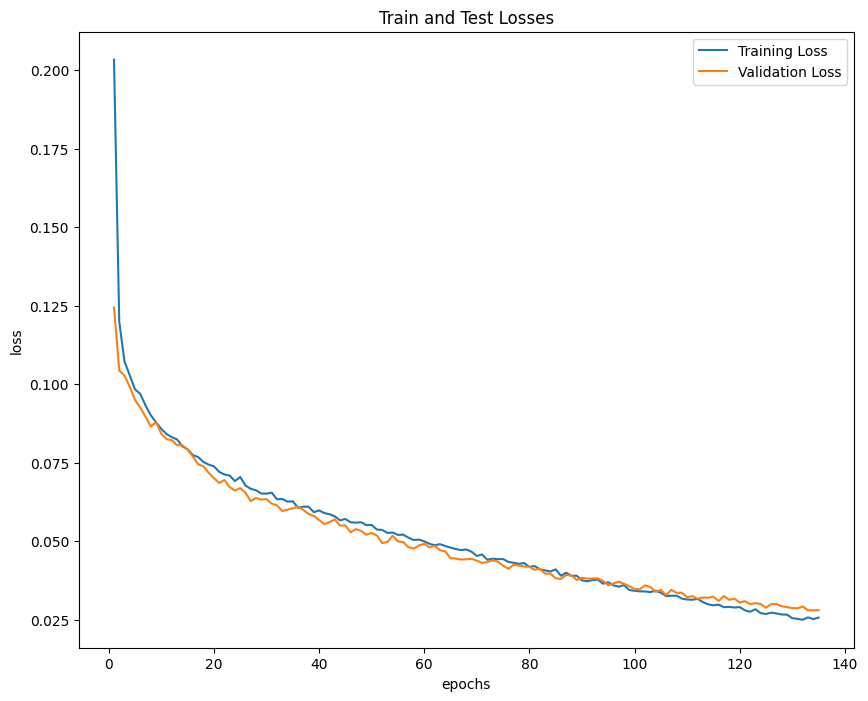

In [84]:

plt.figure(figsize=(10, 8))
plt.plot(range(1,len(tr_loss)+1),tr_loss, label='Training Loss')
plt.plot(range(1,len(te_loss)+1),te_loss,label='Validation Loss')


plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Train and Test Losses')
plt.legend()

plt.show()
